In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from pmdarima.arima import AutoARIMA, ARIMA
from scipy.stats import ttest_1samp, ttest_ind
from antropy import detrended_fluctuation
from tqdm import tqdm

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
from sklearn.model_selection import TimeSeriesSplit

In [2]:
tick = "15m"

df_bars = pd.read_csv(
    f"../data/ohlc_{tick}_gateio.csv", index_col=0, parse_dates=True)
df_close = df_bars.filter(axis="columns", like="close")
df_close.columns = [x.split("_")[0] for x in df_close.columns]

tick = "24h"
df_close = df_close.resample(tick).last()

In [3]:
n_test = 2
df_temp = df_close.loc["2019-01":"2019-04"]
sc = StandardScaler().fit(df_temp.iloc[:-n_test-1])
df_close_norm = pd.DataFrame(sc.transform(df_temp.iloc[:-n_test-1]), index=df_temp.index[:-n_test-1], columns=df_temp.columns)
ica = FastICA(max_iter=5000, algorithm="deflation", fun="exp").fit(df_close_norm)

In [4]:
df_components = pd.DataFrame(ica.components_, index=df_close.columns)

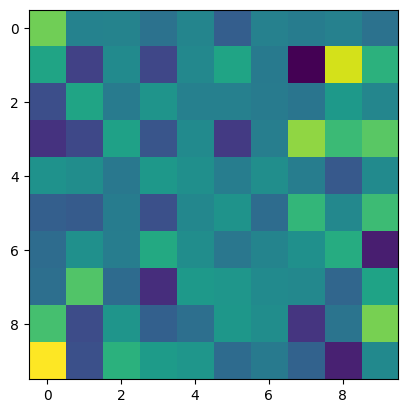

In [5]:
plt.imshow(df_components)

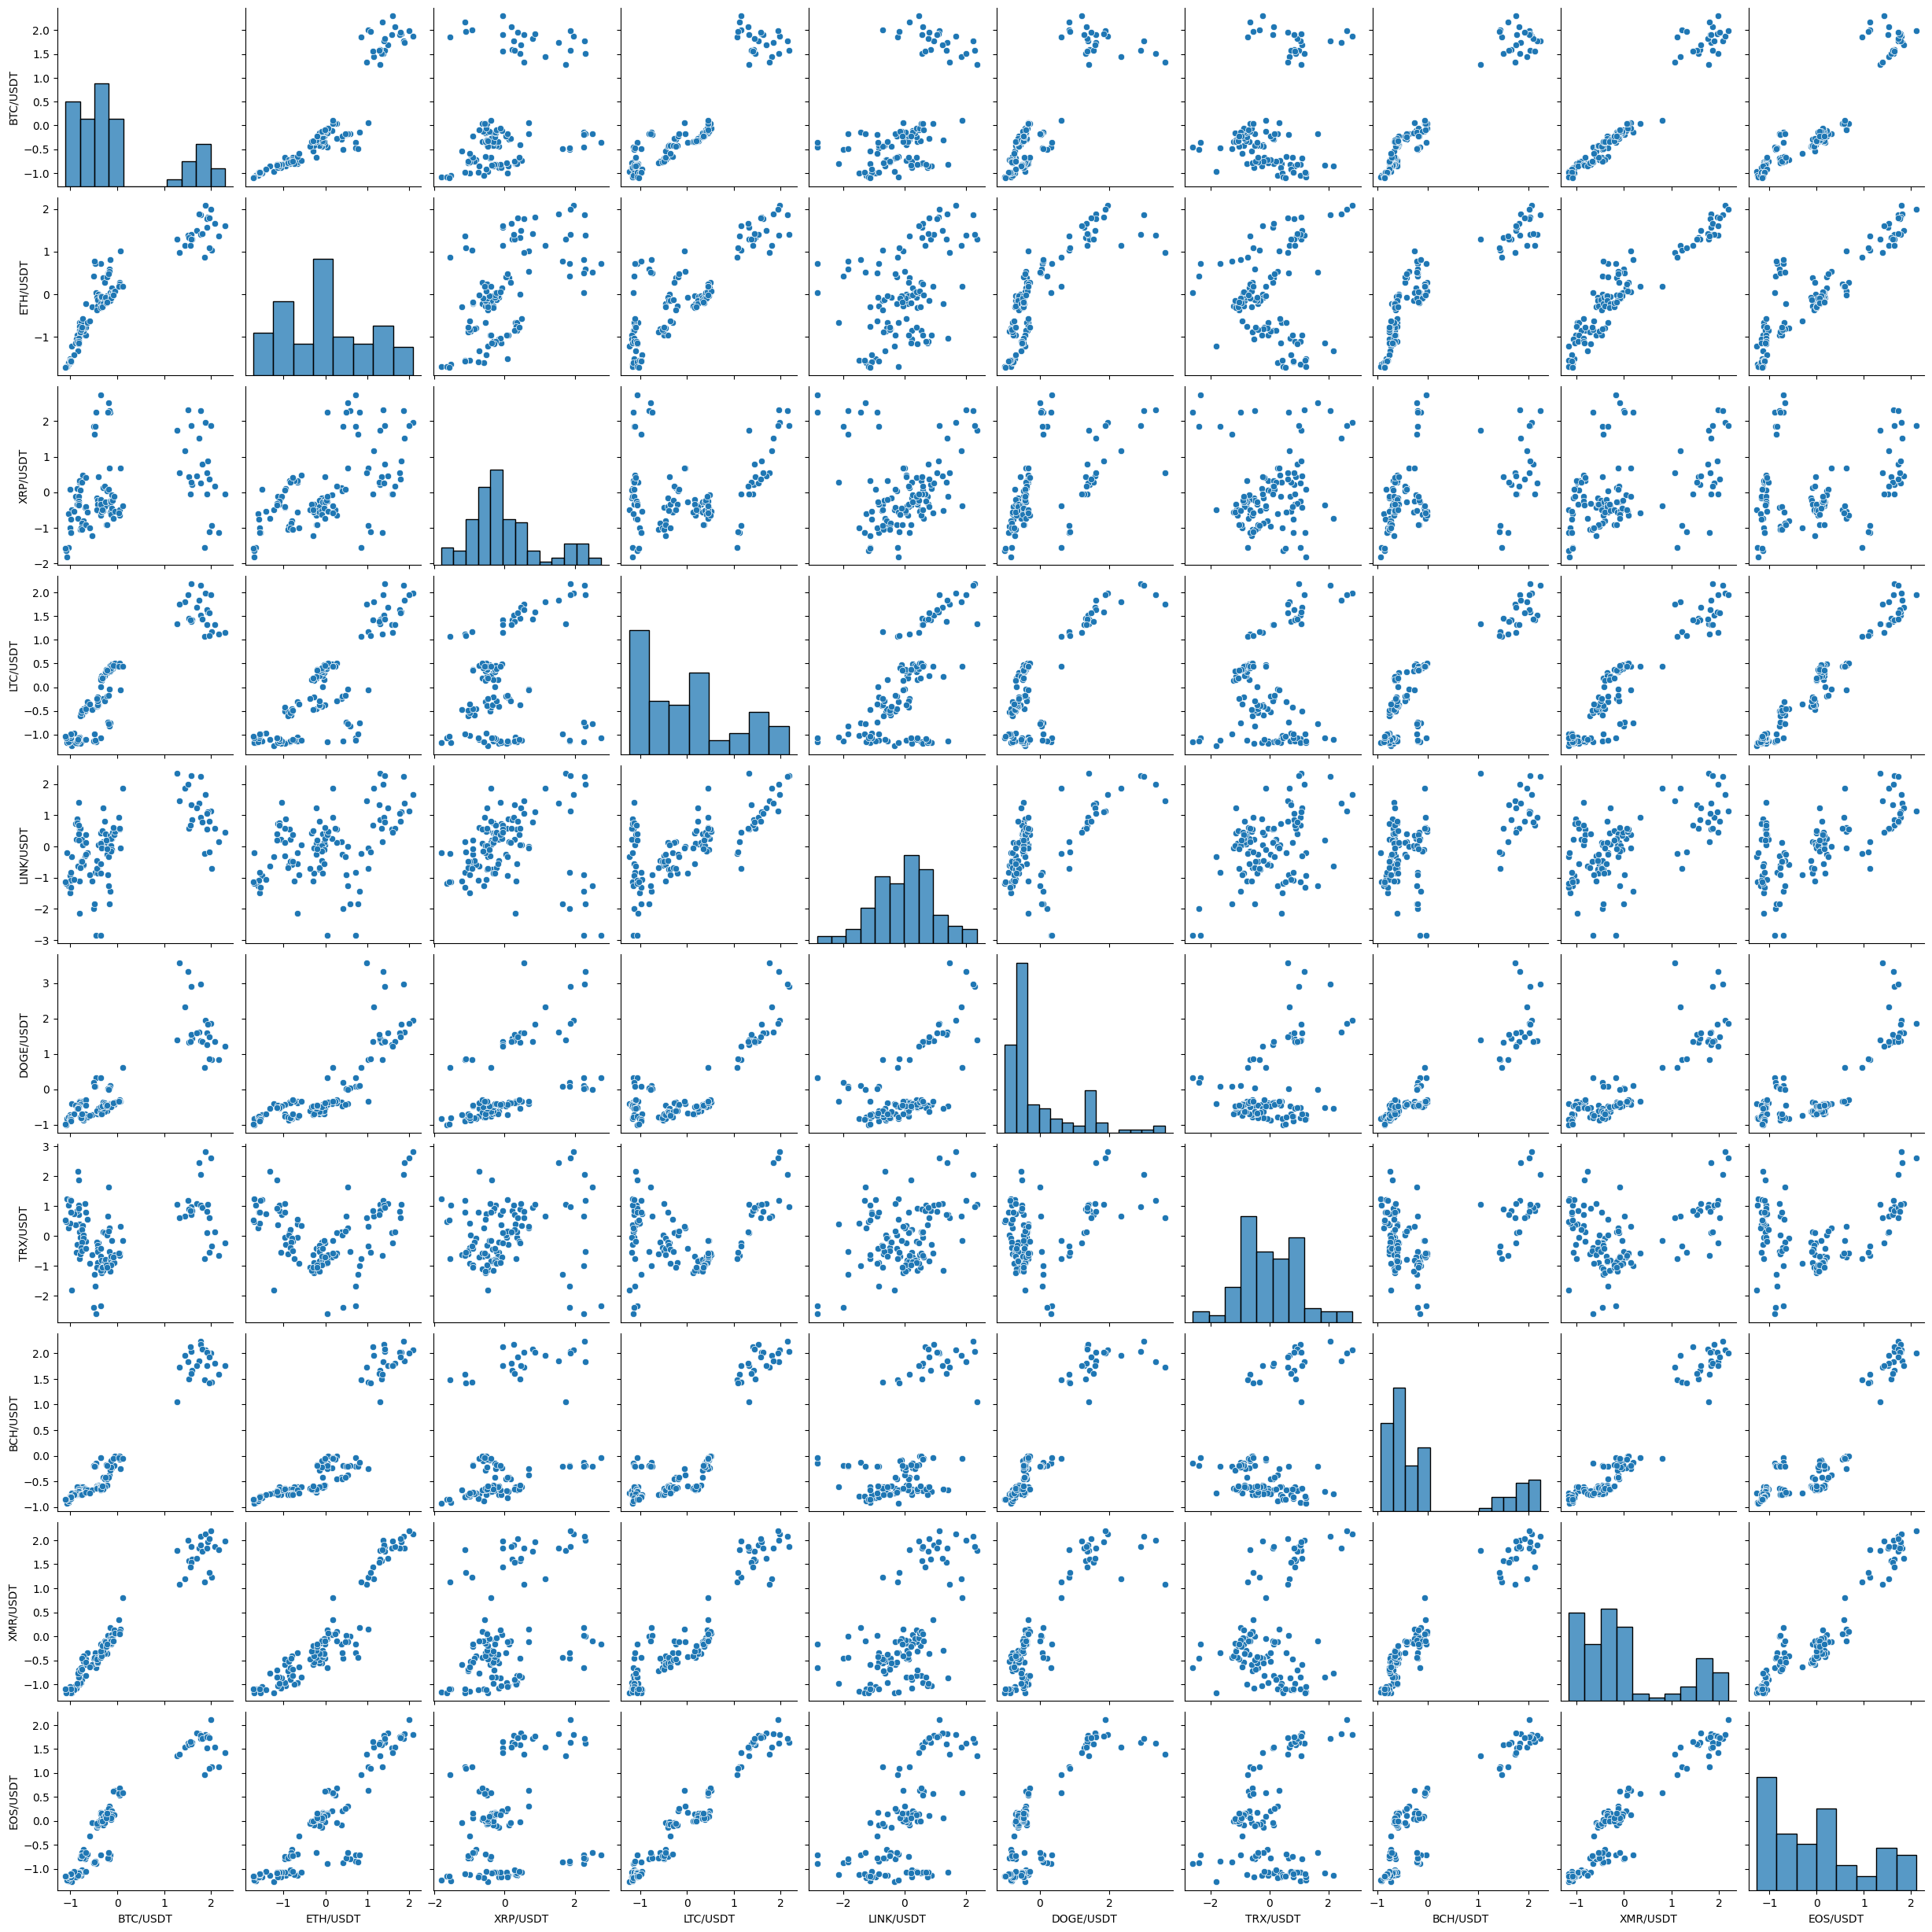

In [6]:
sns.pairplot(df_close_norm)

In [7]:
df_close_trans = pd.DataFrame(ica.transform(df_close_norm.iloc[:-n_test]), index=df_close_norm.iloc[:-n_test].index)

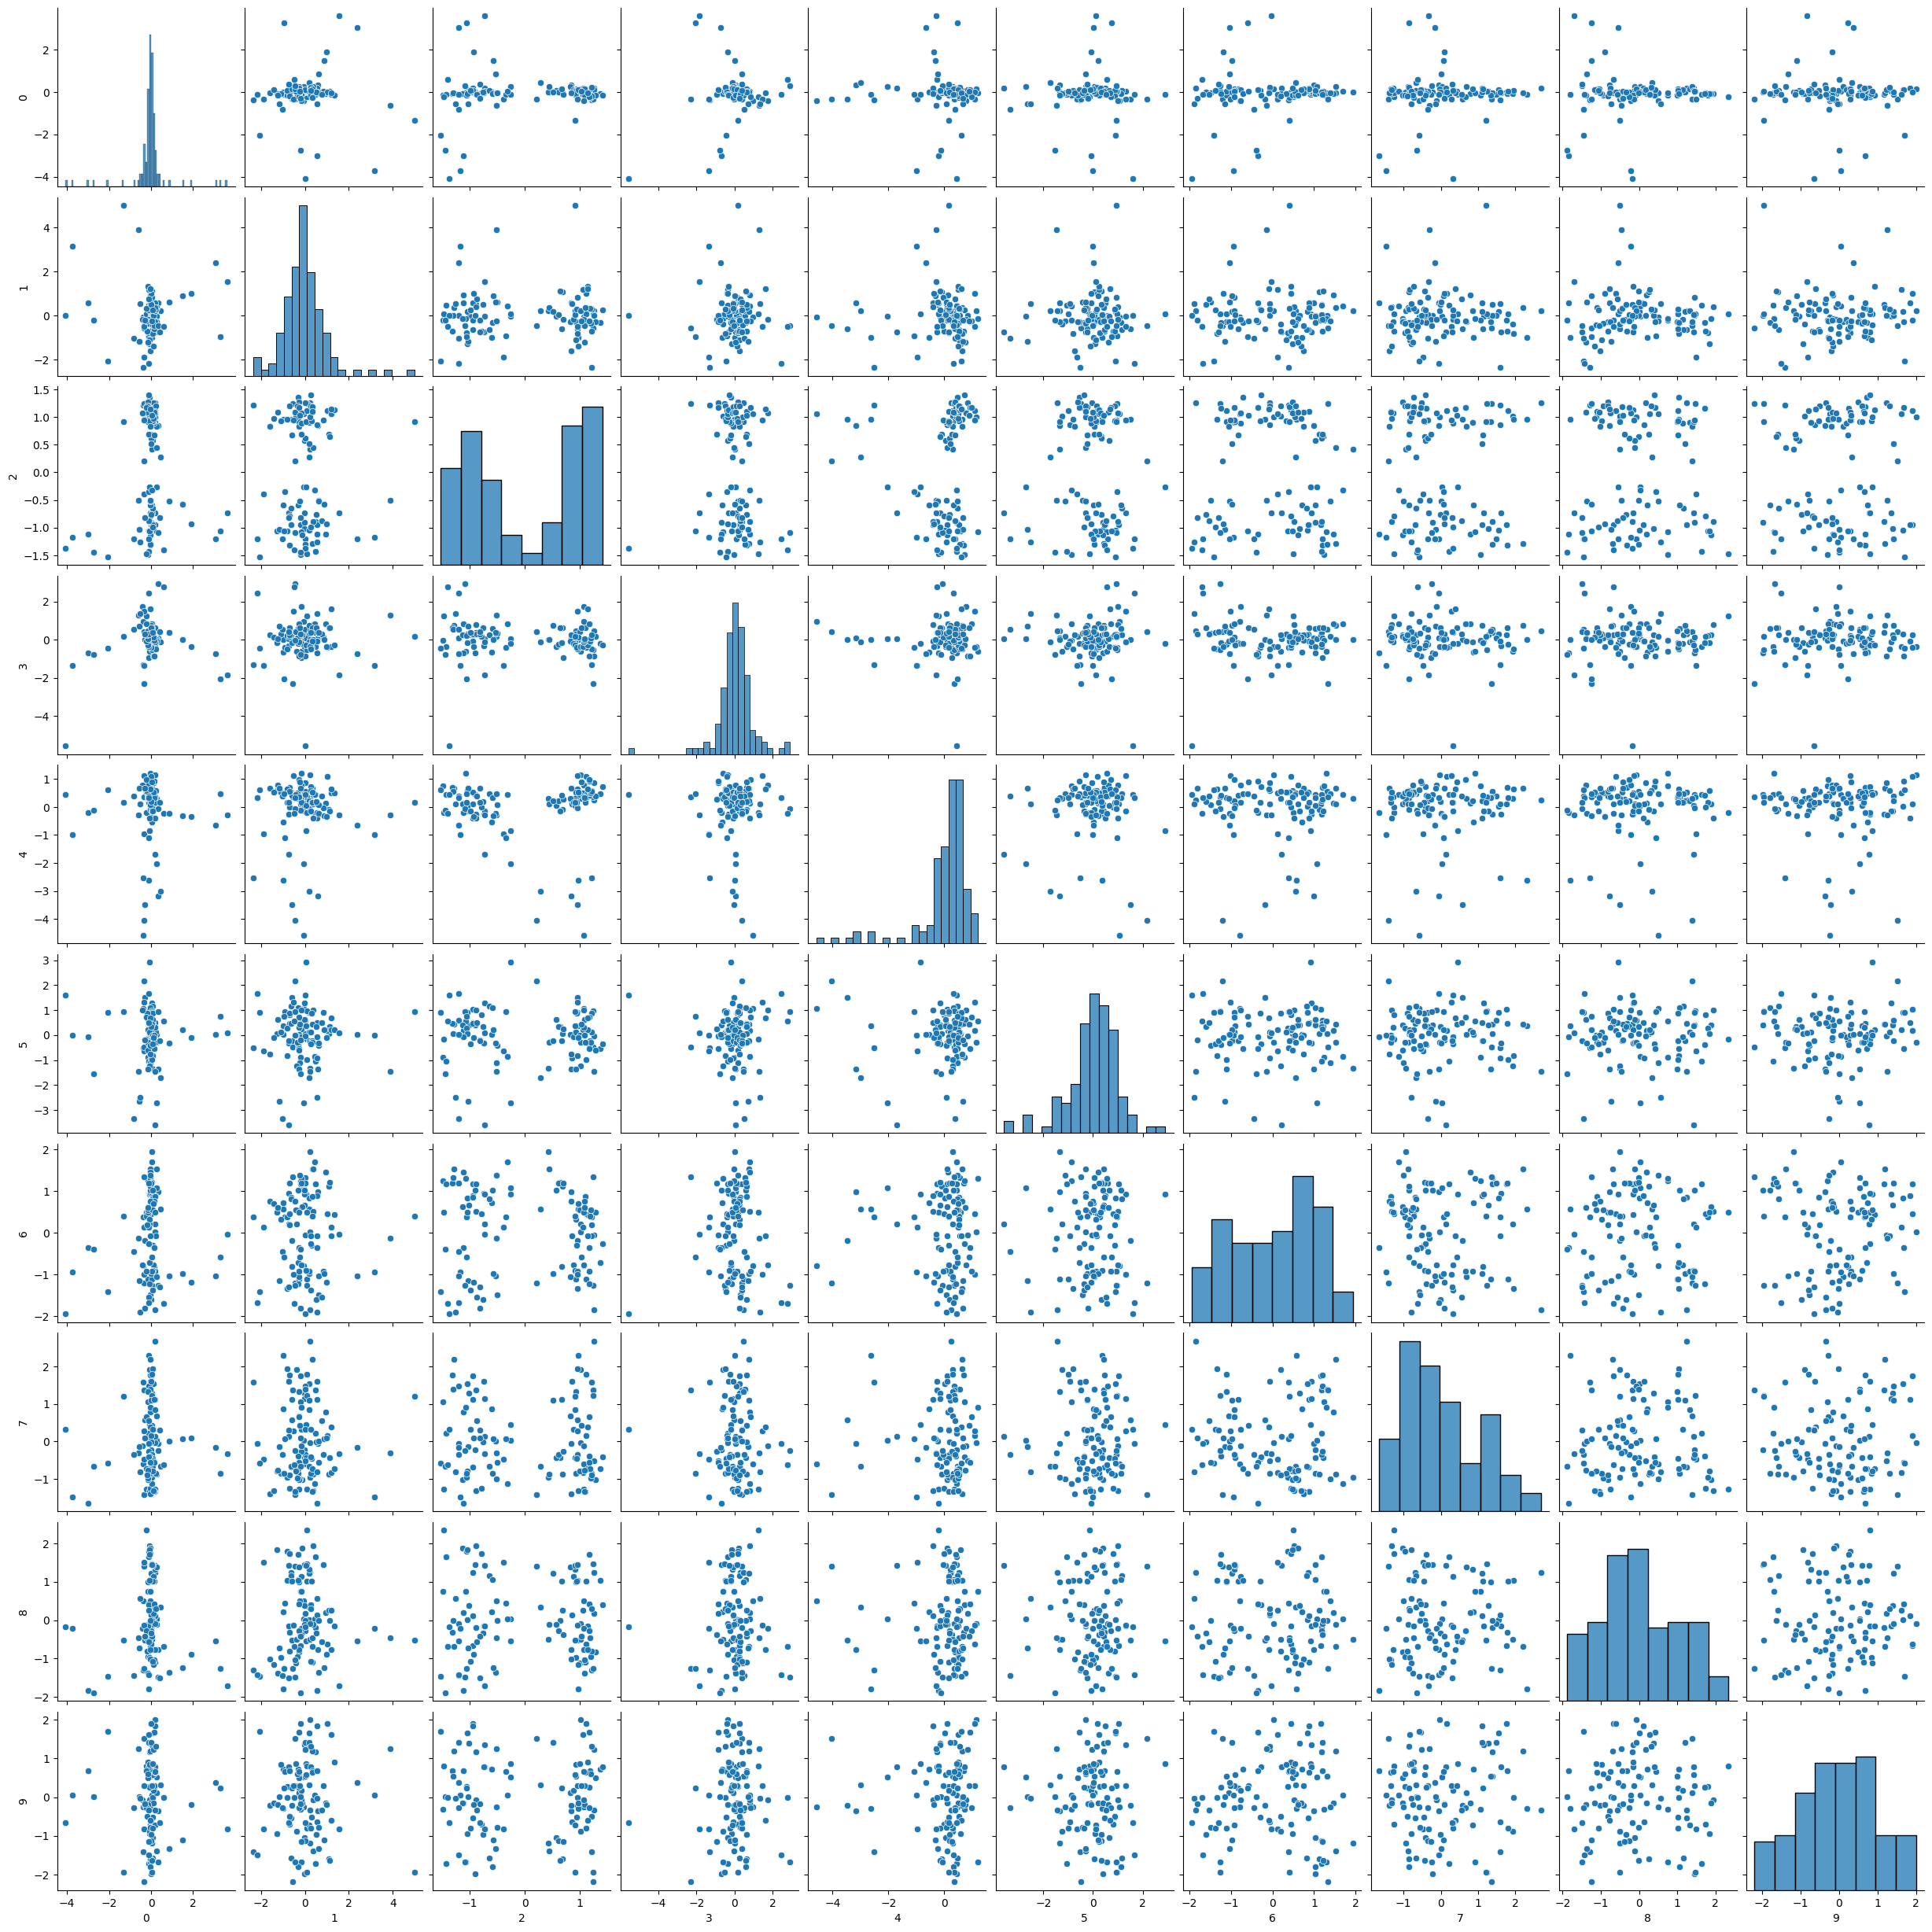

In [8]:
sns.pairplot(df_close_trans)

<Axes: xlabel='timestamp'>

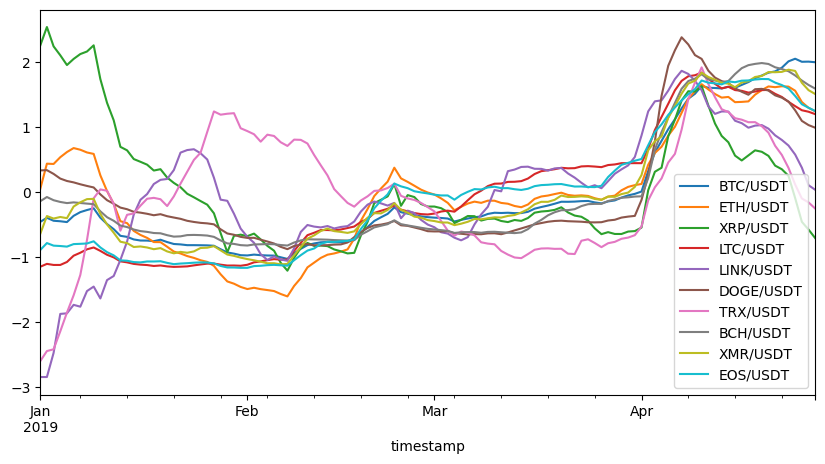

In [9]:
df_close_norm.ewm(span=7).mean().plot(figsize=(10, 5))

(2, 0, 1)


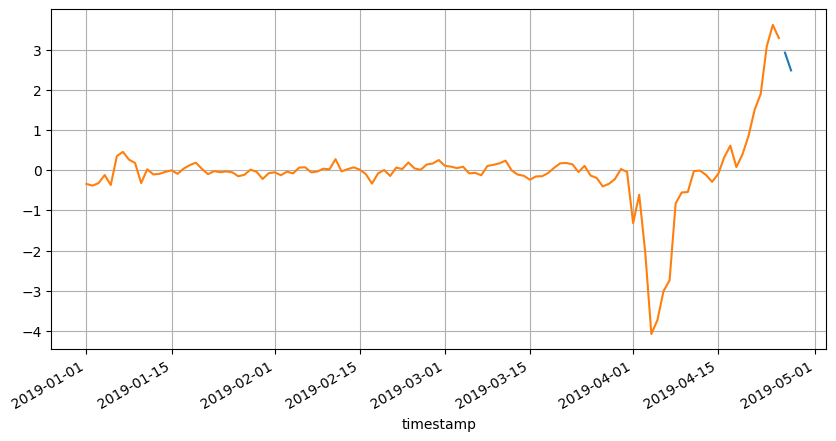

(0, 0, 1)


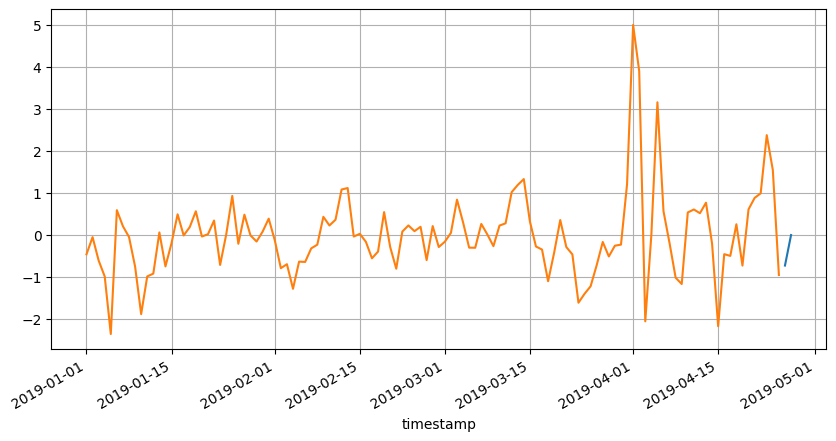

(2, 0, 1)


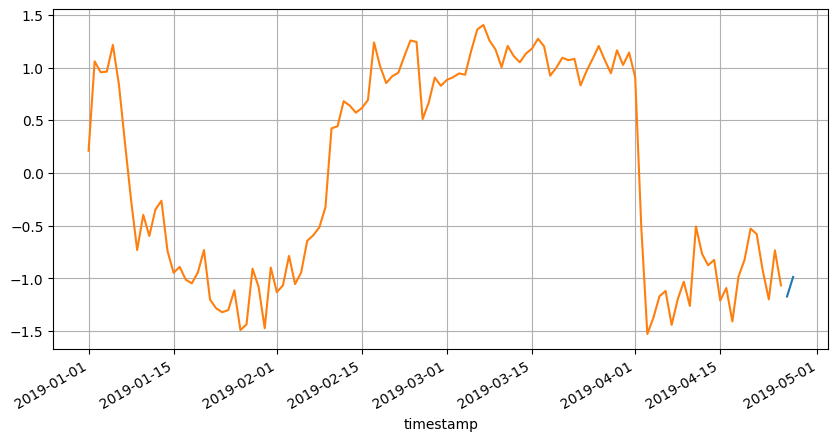

(2, 0, 1)


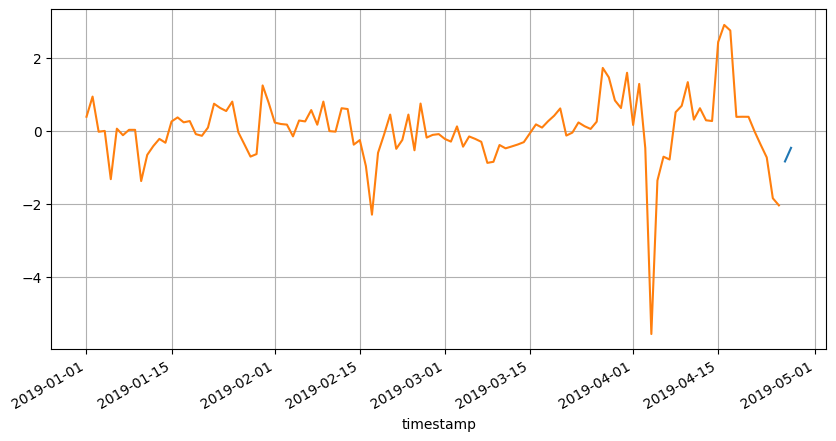

(1, 1, 3)


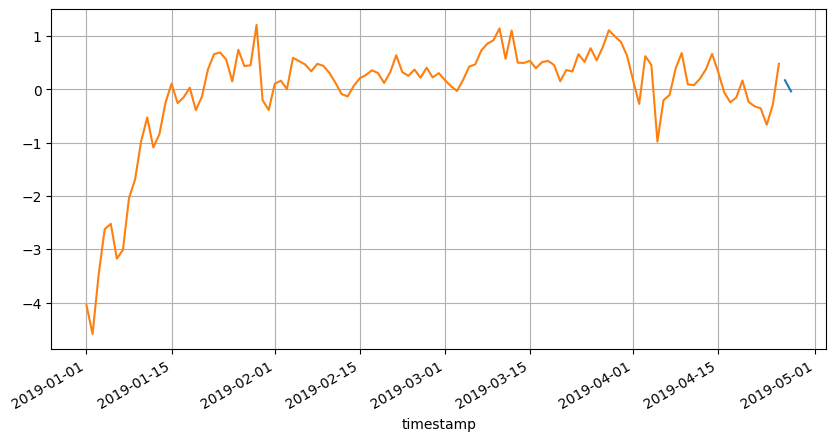

(4, 0, 0)


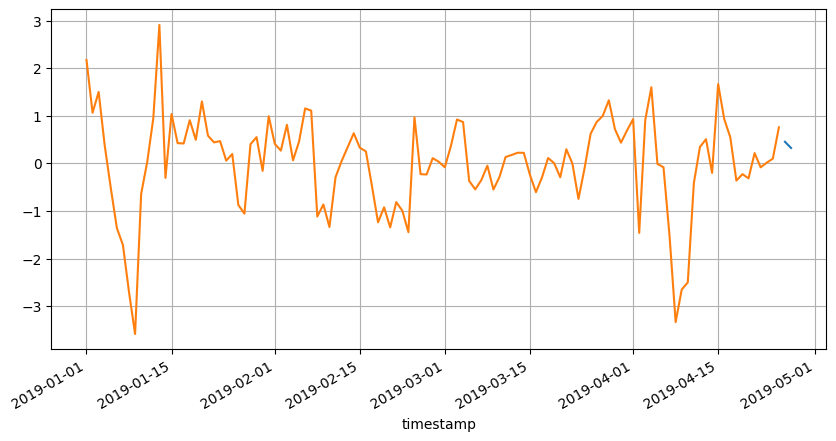

(0, 1, 0)


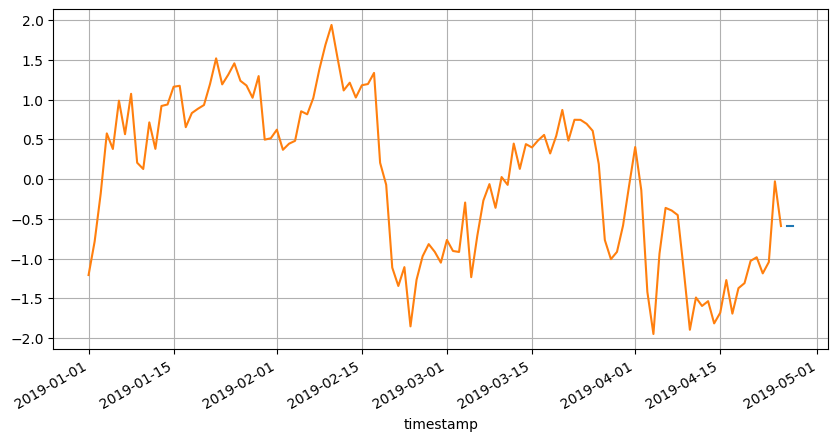

(1, 0, 0)


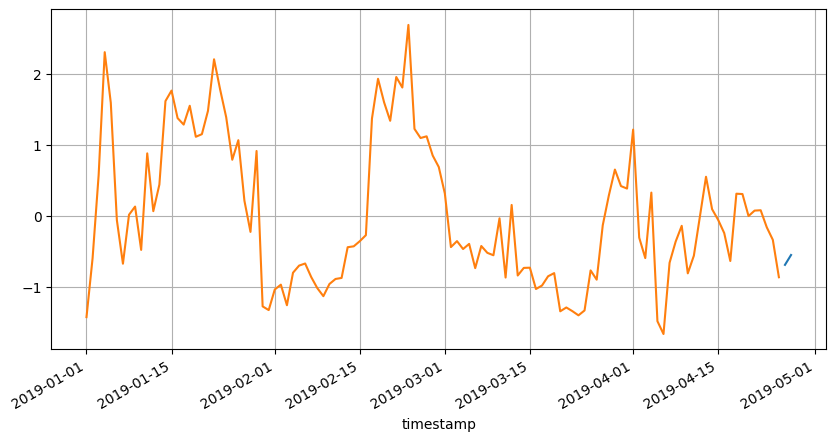

(0, 1, 0)


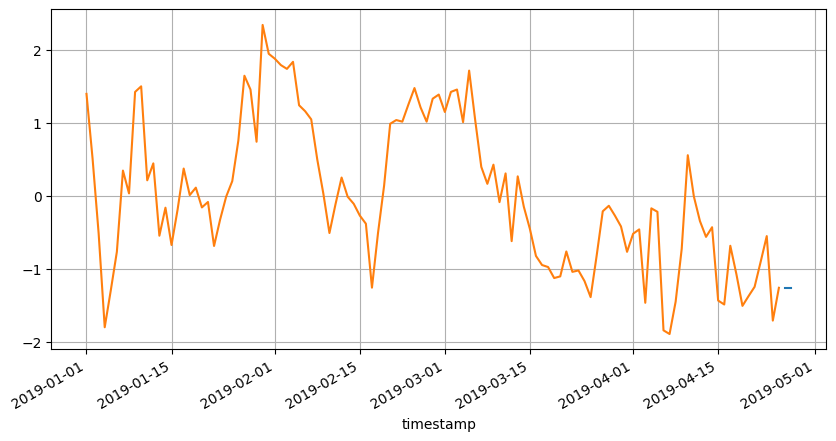

(1, 0, 3)


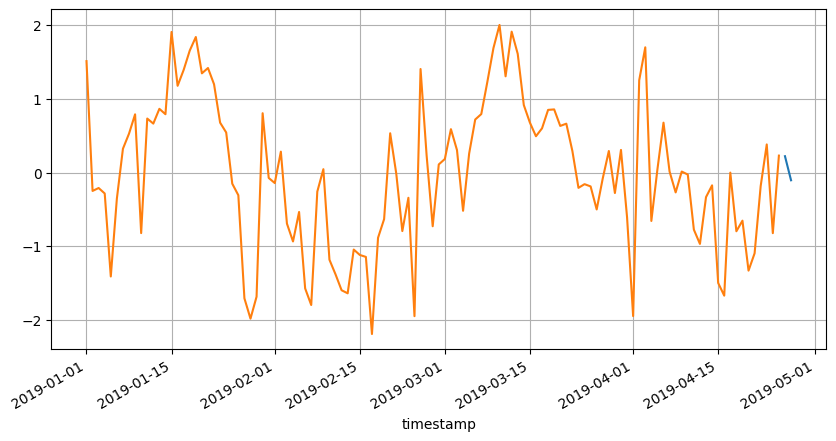

In [10]:
pred_list = []
for c in df_close_trans.columns:
    s = df_close_trans[c]
    aa = AutoARIMA(
        max_p=6, 
        max_q=6, 
        seasonal=False).fit(s)
    order = aa.model_.order
    s_pred = aa.predict(n_test)
    pred_list.append(s_pred)
    print(order)
    plt.plot(s_pred)
    s.plot(figsize=(10, 5), grid=True)
    plt.show()

In [11]:
df_pred = pd.DataFrame(
    sc.inverse_transform(ica.inverse_transform(pd.concat(pred_list, axis=1))), 
    index=pred_list[0].index, 
    columns=df_close_norm.columns)

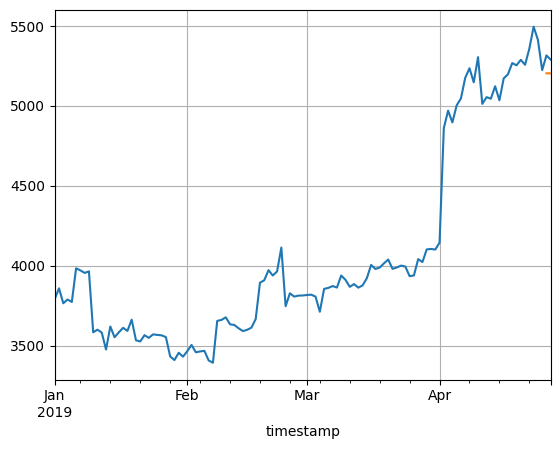

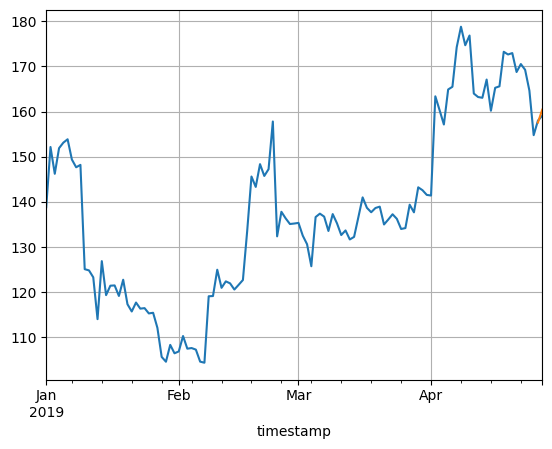

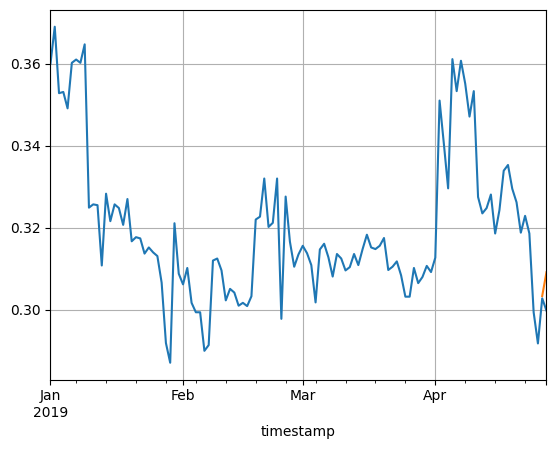

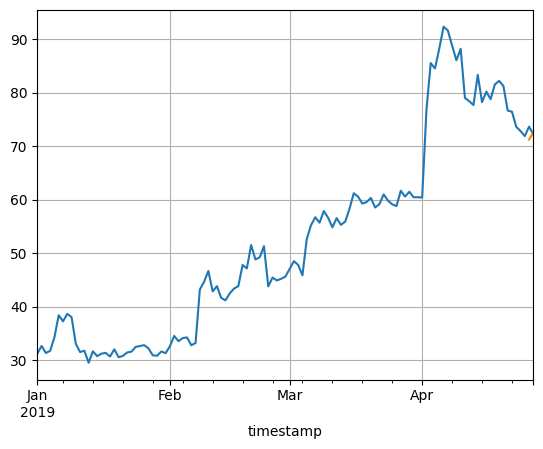

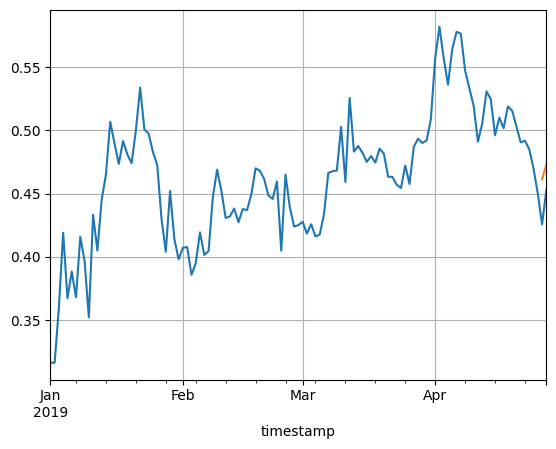

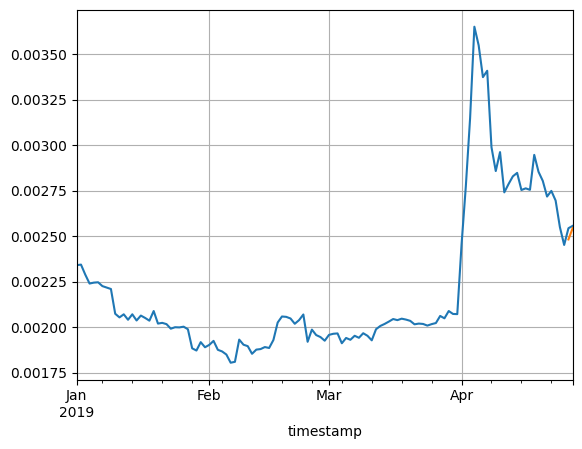

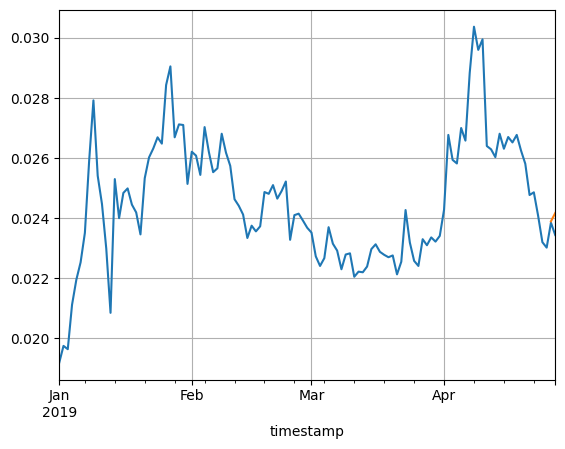

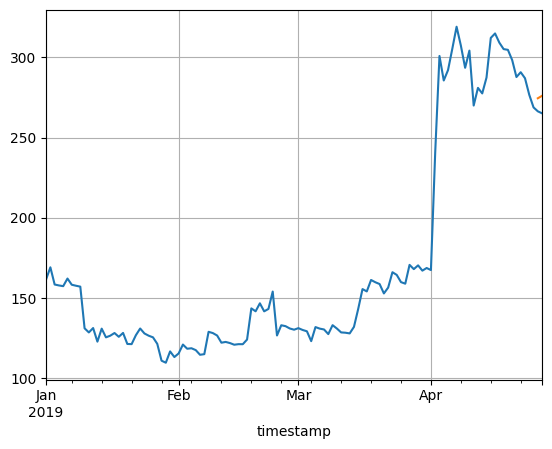

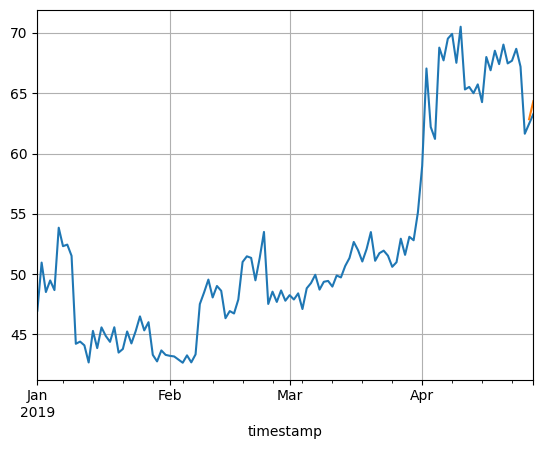

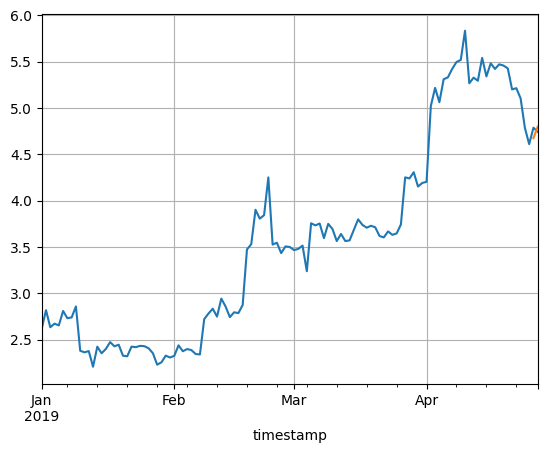

In [12]:
for c in df_pred.columns:
    df_close[c].reindex(df_close_norm.index).plot(grid=True)
    df_pred[c].plot(grid=True)
    plt.show()